## LIBRARY

In [1]:
import pandas as pd
import numpy as np
import scipy.io
from matplotlib import pyplot as plt
from scipy.stats import skew
from scipy.stats import kurtosis

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

import scipy.io
import os
from tqdm import tqdm
import json
from scipy.stats import skew
from scipy.stats import kurtosis
import copy
import warnings
import math
from scipy.linalg import svd
from sklearn.decomposition import PCA
#import antropy as antt
from scipy.stats import entropy
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler(feature_range=(0, 1))
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [2]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
# from math import sqr

## Data Processing

In [3]:
dpath = "./data/"
mpath = "./output_transformer/"

files = os.listdir(dpath)
files.sort()

files = files[:10]
print(files)

['ADANIPORTS.csv', 'ASIANPAINT.csv', 'AXISBANK.csv', 'BAJAJ-AUTO.csv', 'BAJAJFINSV.csv', 'BAJFINANCE.csv', 'BHARTIARTL.csv', 'BPCL.csv', 'BRITANNIA.csv', 'CIPLA.csv']


In [4]:
def sample_creation(data_):
    input_size = 30
    output_size = 7
    
    # Calculate the total number of windows
    total_windows = data_.shape[0] - input_size - output_size + 1
    
    # Initialize lists to store input and output sets
    input_sets = []
    output_sets = []
    
    # Generate input and output sets using sliding window
    for i in range(total_windows):
        input_set = data_[i:i + input_size]
        output_set = data_[i + input_size:i + input_size + output_size]
        input_sets.append(input_set)
        output_sets.append(output_set)
    
    # Convert lists to numpy arrays
    input_sets = np.array(input_sets)
    output_sets = np.array(output_sets)    

    return input_sets, output_sets


def fetch_data(file, scaler):
    
    df=pd.read_csv(dpath + file).set_index('Date')
    df = df[["Close"]]
    
    scaler = MinMaxScaler(feature_range=(-1, 1))
    df['Close'] = scaler.fit_transform(df['Close'].values.reshape(-1,1))

    data = df.values
    
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);

    train_data = data[:train_set_size]
    test_data = data[-test_set_size:]
    
    #test data it is working fine or not
    x_train, y_train = sample_creation(train_data)
    x_test, y_test = sample_creation(test_data)

    return x_train , y_train , x_test , y_test , scaler


## MODEL

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Dropout, LayerNormalization, Input, UpSampling1D
from tensorflow.keras.models import Model
import numpy as np

class ScaledDotProductAttention(Layer):
    def __init__(self, **kwargs):
        super(ScaledDotProductAttention, self).__init__(**kwargs)
    
    def call(self, query, key, value, mask=None):
        matmul_qk = tf.matmul(query, key, transpose_b=True)
        depth = tf.cast(tf.shape(key)[-1], tf.float32)
        logits = matmul_qk / tf.math.sqrt(depth)
        
        if mask is not None:
            logits += (mask * -1e9)
        
        attention_weights = tf.nn.softmax(logits, axis=-1)
        output = tf.matmul(attention_weights, value)
        return output, attention_weights
    
    def get_config(self):
        config = super(ScaledDotProductAttention, self).get_config()
        return config


class MultiHeadAttention(Layer):
    def __init__(self, d_model, num_heads, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % num_heads == 0
        
        self.depth = d_model // num_heads
        self.wq = Dense(d_model)
        self.wk = Dense(d_model)
        self.wv = Dense(d_model)
        self.dense = Dense(d_model)
    
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask=None):
        batch_size = tf.shape(q)[0]
        
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        
        scaled_attention, attention_weights = ScaledDotProductAttention()(q, k, v, mask)
        
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
        
        return output, attention_weights
    
    def get_config(self):
        config = super(MultiHeadAttention, self).get_config()
        config.update({
            "d_model": self.d_model,
            "num_heads": self.num_heads,
        })
        return config


class PointWiseFeedForwardNetwork(Layer):
    def __init__(self, d_model, dff, **kwargs):
        super(PointWiseFeedForwardNetwork, self).__init__(**kwargs)
        self.dense1 = Dense(dff, activation='relu')
        self.dense2 = Dense(d_model)
    
    def call(self, x):
        x = self.dense1(x)
        return self.dense2(x)
    
    def get_config(self):
        config = super(PointWiseFeedForwardNetwork, self).get_config()
        config.update({
            "d_model": self.dense2.units,
            "dff": self.dense1.units,
        })
        return config


class EncoderLayer(Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1, **kwargs):
        super(EncoderLayer, self).__init__(**kwargs)
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = PointWiseFeedForwardNetwork(d_model, dff)
        
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
    
    def call(self, x, training, mask=None):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
    def get_config(self):
        config = super(EncoderLayer, self).get_config()
        config.update({
            "d_model": self.mha.d_model,
            "num_heads": self.mha.num_heads,
            "dff": self.ffn.dense1.units,
            "rate": self.dropout1.rate,
        })
        return config


class Encoder(Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_dim, maximum_position_encoding, rate=0.1, **kwargs):
        super(Encoder, self).__init__(**kwargs)
        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = Dense(d_model)
        self.pos_encoding = self.positional_encoding(maximum_position_encoding, d_model)
        
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = Dropout(rate)
    
    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis], np.arange(d_model)[np.newaxis, :], d_model)
        sines = np.sin(angle_rads[:, 0::2])
        cosines = np.cos(angle_rads[:, 1::2])
        pos_encoding = np.concatenate([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)
    
    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return pos * angle_rates
    
    def call(self, x, training, mask=None):
        seq_len = tf.shape(x)[1]
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        
        return x
    
    def get_config(self):
        config = super(Encoder, self).get_config()
        config.update({
            "num_layers": self.num_layers,
            "d_model": self.d_model,
            "num_heads": self.enc_layers[0].mha.num_heads,
            "dff": self.enc_layers[0].ffn.dense1.units,
            "input_dim": self.embedding.units,
            "maximum_position_encoding": self.pos_encoding.shape[1],
            "rate": self.dropout.rate,
        })
        return config


def build_transformer_model(input_shape, num_layers, d_model, num_heads, dff, maximum_position_encoding, output_shape, rate=0.1):
    inputs = Input(shape=input_shape)
    mask = None  # Add mask if necessary
    encoder1 = Encoder(num_layers, d_model, num_heads, dff, input_shape[-1], maximum_position_encoding, rate)
    enc_output1 = encoder1(inputs, training=True, mask=mask)

    #up1 = UpSampling1D(size = 2)(enc_output1)
    print("enc_output1.shape",enc_output1.shape)
    outputs = Dense(output_shape[-1])(enc_output1[:,-7:,:])
    
    return Model(inputs=inputs, outputs=outputs)


input_shape = (30, 1)  # 96 time steps, 7 features
num_layers = 2
d_model = 512
num_heads = 8
dff = 2048
maximum_position_encoding = 10000
output_shape = (7, 1)  # 96 time steps, 7 features

transformer_model = build_transformer_model(input_shape, num_layers, d_model, num_heads, dff, maximum_position_encoding, output_shape)
transformer_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

transformer_model.summary()


2024-10-18 21:58:29.506570: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-10-18 21:58:29.506611: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-10-18 21:58:35.354399: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-10-18 21:58:35.354586: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-10-18 21:58:35.354702: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: lib

enc_output1.shape (None, 30, 512)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 1)]           0         
                                                                 
 encoder (Encoder)           (None, 30, 512)           6305792   
                                                                 
 tf.__operators__.getitem (S  (None, 7, 512)           0         
 licingOpLambda)                                                 
                                                                 
 dense_13 (Dense)            (None, 7, 1)              513       
                                                                 
Total params: 6,306,305
Trainable params: 6,306,305
Non-trainable params: 0
_________________________________________________________________


In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.callbacks import EarlyStopping

## TRAINING

In [7]:
def root_mean_square_error(array1, array2):
    # Ensure the two arrays have the same shape
    if array1.shape != array2.shape:
        raise ValueError("The shapes of the input arrays must be the same.")
    
    # Compute the element-wise differences
    difference = array1 - array2
    
    # Square the differences
    squared_difference = np.square(difference)
    
    # Compute the mean of the squared differences
    mse = np.mean(squared_difference)

    error = mse ** 0.5
    
    return error

In [8]:
def mean_absolute_error(array1, array2):
    # Ensure the two arrays have the same shape
    if array1.shape != array2.shape:
        raise ValueError("The shapes of the input arrays must be the same.")
    
    # Compute the element-wise differences
    difference = array1 - array2
    
    # Take the absolute value of the differences
    absolute_difference = np.abs(difference)
    
    # Compute the mean of the absolute differences
    error = np.mean(absolute_difference)
    
    return error

  0%|                                                                                            | 0/10 [00:00<?, ?it/s]

Epoch 1/100
82/82 [==============================] - ETA: 0s - loss: 9.5878 - mae: 1.0726
Epoch 1: val_loss improved from inf to 0.40618, saving model to ./weights_transformer/ADANIPORTS.csv.h5
82/82 [==============================] - 29s 298ms/step - loss: 9.5878 - mae: 1.0726 - val_loss: 0.4062 - val_mae: 0.5216
Epoch 2/100
82/82 [==============================] - ETA: 0s - loss: 0.1100 - mae: 0.2675
Epoch 2: val_loss did not improve from 0.40618
82/82 [==============================] - 19s 231ms/step - loss: 0.1100 - mae: 0.2675 - val_loss: 0.4850 - val_mae: 0.4144
Epoch 3/100
82/82 [==============================] - ETA: 0s - loss: 0.0600 - mae: 0.1947
Epoch 3: val_loss did not improve from 0.40618
82/82 [==============================] - 19s 228ms/step - loss: 0.0600 - mae: 0.1947 - val_loss: 0.6487 - val_mae: 0.4055
Epoch 4/100
82/82 [==============================] - ETA: 0s - loss: 0.0430 - mae: 0.1649
Epoch 4: val_loss did not improve from 0.40618
82/82 [======================

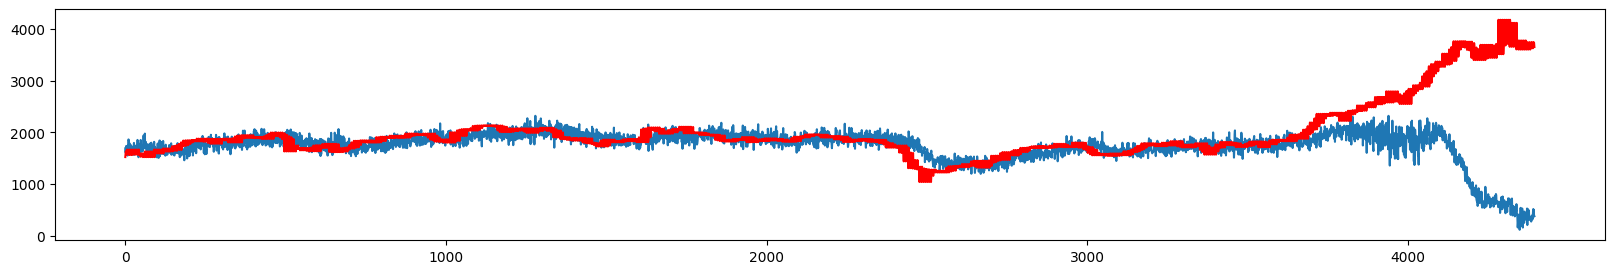

 10%|████████▎                                                                          | 1/10 [05:30<49:31, 330.19s/it]

Epoch 1/100
132/132 [==============================] - ETA: 0s - loss: 0.0031 - mae: 0.0437
Epoch 1: val_loss improved from inf to 0.39943, saving model to ./weights_transformer/ASIANPAINT.csv.h5
132/132 [==============================] - 40s 306ms/step - loss: 0.0031 - mae: 0.0437 - val_loss: 0.3994 - val_mae: 0.3678
Epoch 2/100
132/132 [==============================] - ETA: 0s - loss: 0.0020 - mae: 0.0350
Epoch 2: val_loss improved from 0.39943 to 0.37091, saving model to ./weights_transformer/ASIANPAINT.csv.h5
132/132 [==============================] - 40s 302ms/step - loss: 0.0020 - mae: 0.0350 - val_loss: 0.3709 - val_mae: 0.3287
Epoch 3/100
132/132 [==============================] - ETA: 0s - loss: 0.0018 - mae: 0.0335
Epoch 3: val_loss improved from 0.37091 to 0.36261, saving model to ./weights_transformer/ASIANPAINT.csv.h5
132/132 [==============================] - 41s 313ms/step - loss: 0.0018 - mae: 0.0335 - val_loss: 0.3626 - val_mae: 0.3305
Epoch 4/100
132/132 [===========

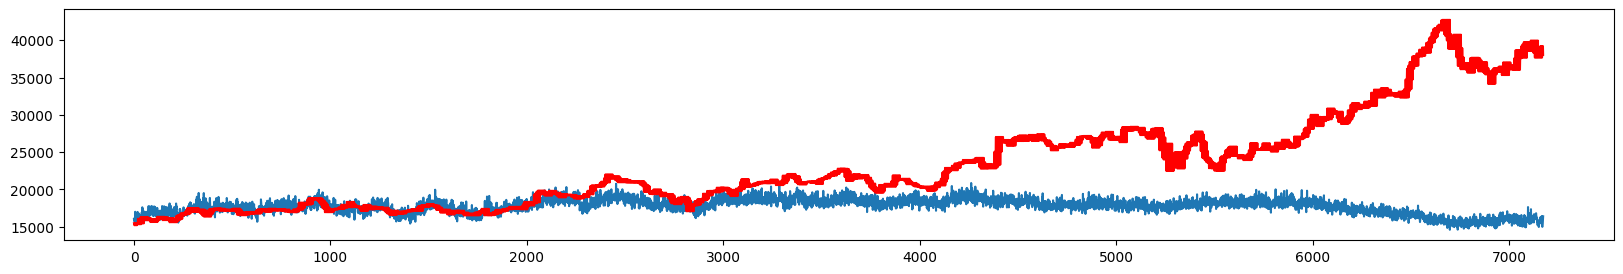

 20%|████████████████                                                                | 2/10 [39:54<3:00:02, 1350.33s/it]

Epoch 1/100
132/132 [==============================] - ETA: 0s - loss: 0.2004 - mae: 0.3567
Epoch 1: val_loss improved from inf to 1.80875, saving model to ./weights_transformer/AXISBANK.csv.h5
132/132 [==============================] - 38s 290ms/step - loss: 0.2004 - mae: 0.3567 - val_loss: 1.8088 - val_mae: 1.3156
Epoch 2/100
132/132 [==============================] - ETA: 0s - loss: 0.1754 - mae: 0.3393
Epoch 2: val_loss improved from 1.80875 to 0.63684, saving model to ./weights_transformer/AXISBANK.csv.h5
132/132 [==============================] - 38s 291ms/step - loss: 0.1754 - mae: 0.3393 - val_loss: 0.6368 - val_mae: 0.7566
Epoch 3/100
132/132 [==============================] - ETA: 0s - loss: 0.0109 - mae: 0.0652
Epoch 3: val_loss improved from 0.63684 to 0.03534, saving model to ./weights_transformer/AXISBANK.csv.h5
132/132 [==============================] - 36s 276ms/step - loss: 0.0109 - mae: 0.0652 - val_loss: 0.0353 - val_mae: 0.1413
Epoch 4/100
132/132 [=================

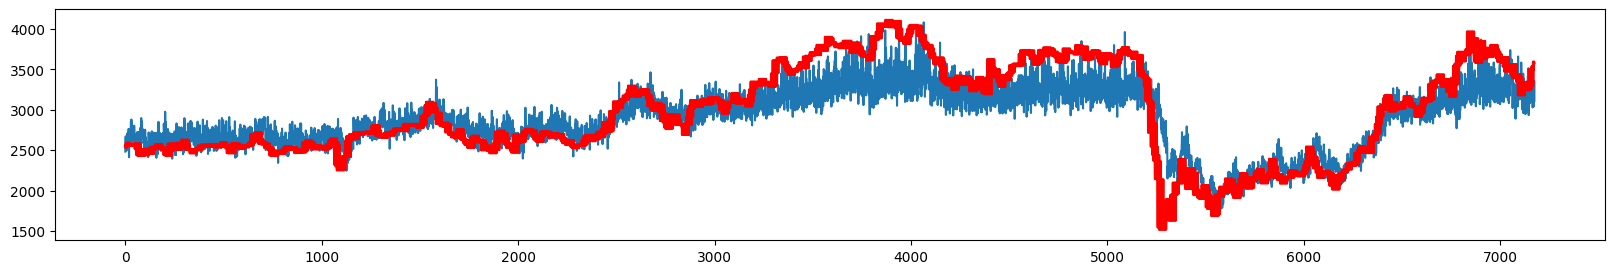

 30%|████████████████████████                                                        | 3/10 [52:20<2:05:21, 1074.55s/it]

Epoch 1/100
79/79 [==============================] - ETA: 0s - loss: 0.0032 - mae: 0.0452
Epoch 1: val_loss improved from inf to 0.00921, saving model to ./weights_transformer/BAJAJ-AUTO.csv.h5
79/79 [==============================] - 23s 294ms/step - loss: 0.0032 - mae: 0.0452 - val_loss: 0.0092 - val_mae: 0.0660
Epoch 2/100
79/79 [==============================] - ETA: 0s - loss: 0.0021 - mae: 0.0351
Epoch 2: val_loss did not improve from 0.00921
79/79 [==============================] - 22s 275ms/step - loss: 0.0021 - mae: 0.0351 - val_loss: 0.0124 - val_mae: 0.0846
Epoch 3/100
79/79 [==============================] - ETA: 0s - loss: 0.0022 - mae: 0.0366
Epoch 3: val_loss improved from 0.00921 to 0.00664, saving model to ./weights_transformer/BAJAJ-AUTO.csv.h5
79/79 [==============================] - 19s 245ms/step - loss: 0.0022 - mae: 0.0366 - val_loss: 0.0066 - val_mae: 0.0566
Epoch 4/100
79/79 [==============================] - ETA: 0s - loss: 0.0026 - mae: 0.0398
Epoch 4: val_lo

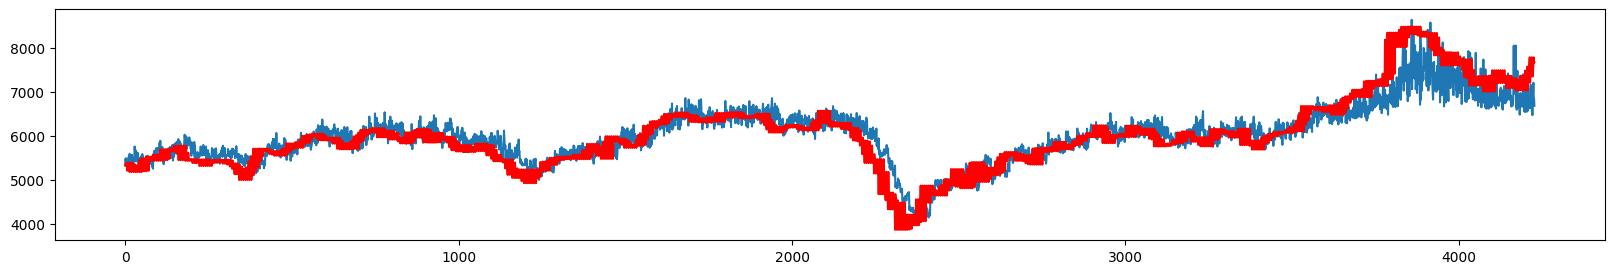

 40%|████████████████████████████████▍                                                | 4/10 [57:45<1:17:51, 778.54s/it]

Epoch 1/100
79/79 [==============================] - ETA: 0s - loss: 0.0018 - mae: 0.0343
Epoch 1: val_loss improved from inf to 0.01320, saving model to ./weights_transformer/BAJAJFINSV.csv.h5
79/79 [==============================] - 22s 281ms/step - loss: 0.0018 - mae: 0.0343 - val_loss: 0.0132 - val_mae: 0.0824
Epoch 2/100
79/79 [==============================] - ETA: 0s - loss: 0.0013 - mae: 0.0285
Epoch 2: val_loss did not improve from 0.01320
79/79 [==============================] - 22s 276ms/step - loss: 0.0013 - mae: 0.0285 - val_loss: 0.0195 - val_mae: 0.1044
Epoch 3/100
79/79 [==============================] - ETA: 0s - loss: 8.9738e-04 - mae: 0.0227
Epoch 3: val_loss did not improve from 0.01320
79/79 [==============================] - 23s 287ms/step - loss: 8.9738e-04 - mae: 0.0227 - val_loss: 0.0256 - val_mae: 0.1200
Epoch 4/100
79/79 [==============================] - ETA: 0s - loss: 8.5279e-04 - mae: 0.0222
Epoch 4: val_loss did not improve from 0.01320
79/79 [==========

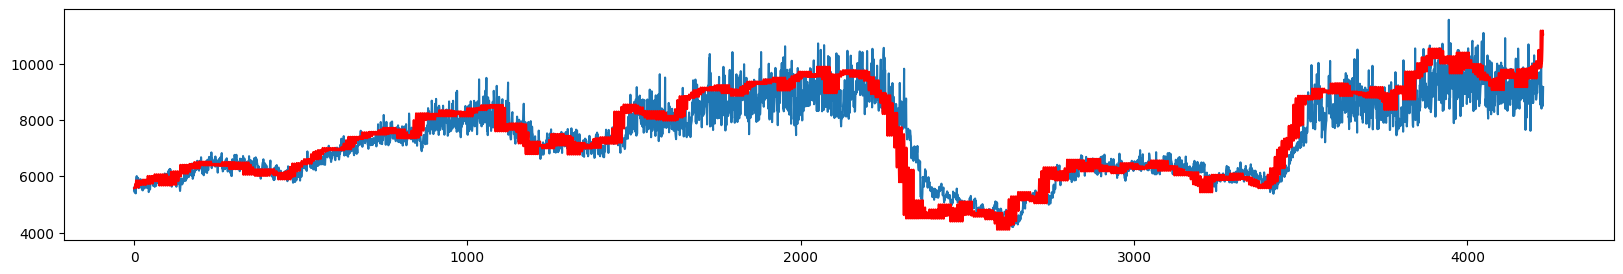

 50%|█████████████████████████████████████████▌                                         | 5/10 [59:52<45:17, 543.41s/it]

Epoch 1/100
130/130 [==============================] - ETA: 0s - loss: 8.8505e-04 - mae: 0.0216
Epoch 1: val_loss improved from inf to 0.04378, saving model to ./weights_transformer/BAJFINANCE.csv.h5
130/130 [==============================] - 38s 294ms/step - loss: 8.8505e-04 - mae: 0.0216 - val_loss: 0.0438 - val_mae: 0.1541
Epoch 2/100
130/130 [==============================] - ETA: 0s - loss: 7.1511e-04 - mae: 0.0189
Epoch 2: val_loss improved from 0.04378 to 0.02890, saving model to ./weights_transformer/BAJFINANCE.csv.h5
130/130 [==============================] - 38s 291ms/step - loss: 7.1511e-04 - mae: 0.0189 - val_loss: 0.0289 - val_mae: 0.1144
Epoch 3/100
130/130 [==============================] - ETA: 0s - loss: 5.9360e-04 - mae: 0.0170
Epoch 3: val_loss did not improve from 0.02890
130/130 [==============================] - 37s 288ms/step - loss: 5.9360e-04 - mae: 0.0170 - val_loss: 0.0379 - val_mae: 0.1341
Epoch 4/100
130/130 [==============================] - ETA: 0s - loss

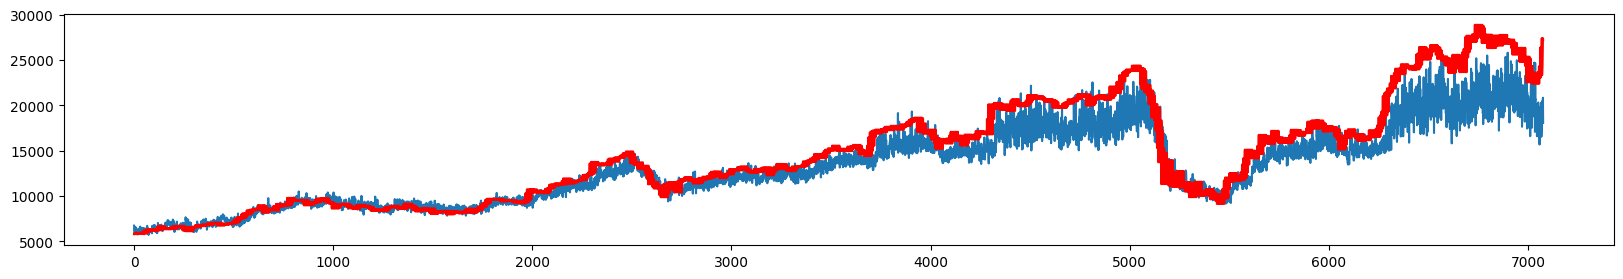

 60%|████████████████████████████████████████████████▌                                | 6/10 [1:04:17<29:55, 448.99s/it]

Epoch 1/100
119/119 [==============================] - ETA: 0s - loss: 0.2311 - mae: 0.3929
Epoch 1: val_loss improved from inf to 0.34196, saving model to ./weights_transformer/BHARTIARTL.csv.h5
119/119 [==============================] - 31s 260ms/step - loss: 0.2311 - mae: 0.3929 - val_loss: 0.3420 - val_mae: 0.5079
Epoch 2/100
119/119 [==============================] - ETA: 0s - loss: 0.2035 - mae: 0.3743
Epoch 2: val_loss did not improve from 0.34196
119/119 [==============================] - 30s 250ms/step - loss: 0.2035 - mae: 0.3743 - val_loss: 0.4162 - val_mae: 0.5765
Epoch 3/100
119/119 [==============================] - ETA: 0s - loss: 0.2031 - mae: 0.3759
Epoch 3: val_loss improved from 0.34196 to 0.29484, saving model to ./weights_transformer/BHARTIARTL.csv.h5
119/119 [==============================] - 31s 260ms/step - loss: 0.2031 - mae: 0.3759 - val_loss: 0.2948 - val_mae: 0.4597
Epoch 4/100
119/119 [==============================] - ETA: 0s - loss: 0.2049 - mae: 0.3756
E

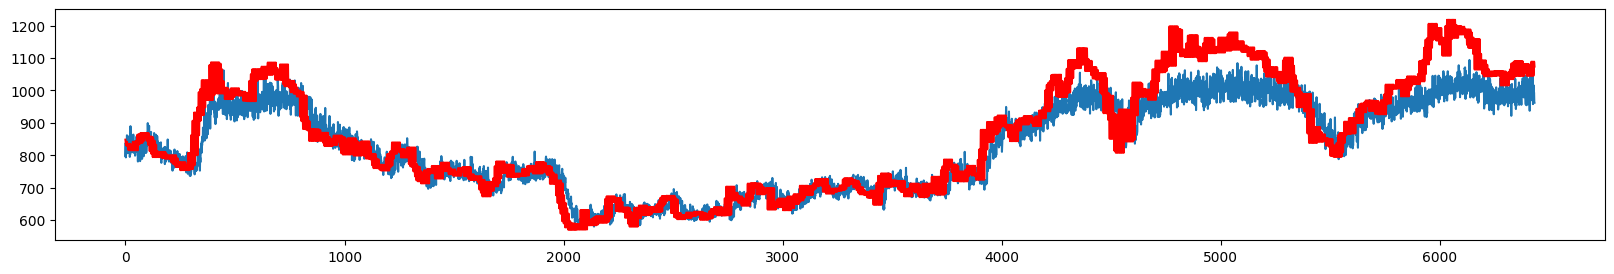

 70%|████████████████████████████████████████████████████████▋                        | 7/10 [1:14:28<25:05, 501.70s/it]

Epoch 1/100
132/132 [==============================] - ETA: 0s - loss: 0.0023 - mae: 0.0384
Epoch 1: val_loss improved from inf to 0.02114, saving model to ./weights_transformer/BPCL.csv.h5
132/132 [==============================] - 22s 170ms/step - loss: 0.0023 - mae: 0.0384 - val_loss: 0.0211 - val_mae: 0.1112
Epoch 2/100
132/132 [==============================] - ETA: 0s - loss: 0.0012 - mae: 0.0271
Epoch 2: val_loss improved from 0.02114 to 0.01904, saving model to ./weights_transformer/BPCL.csv.h5
132/132 [==============================] - 22s 164ms/step - loss: 0.0012 - mae: 0.0271 - val_loss: 0.0190 - val_mae: 0.1060
Epoch 3/100
132/132 [==============================] - ETA: 0s - loss: 0.0011 - mae: 0.0249
Epoch 3: val_loss improved from 0.01904 to 0.01690, saving model to ./weights_transformer/BPCL.csv.h5
132/132 [==============================] - 22s 164ms/step - loss: 0.0011 - mae: 0.0249 - val_loss: 0.0169 - val_mae: 0.1025
Epoch 4/100
132/132 [=============================

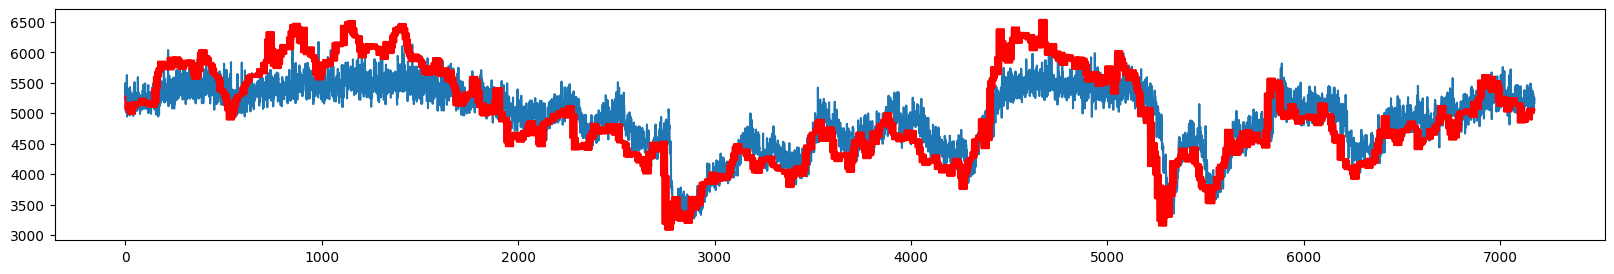

 80%|████████████████████████████████████████████████████████████████▊                | 8/10 [1:17:19<13:12, 396.48s/it]

Epoch 1/100
132/132 [==============================] - ETA: 0s - loss: 6.2937e-04 - mae: 0.0195
Epoch 1: val_loss improved from inf to 0.04846, saving model to ./weights_transformer/BRITANNIA.csv.h5
132/132 [==============================] - 23s 173ms/step - loss: 6.2937e-04 - mae: 0.0195 - val_loss: 0.0485 - val_mae: 0.1763
Epoch 2/100
132/132 [==============================] - ETA: 0s - loss: 4.9374e-04 - mae: 0.0172
Epoch 2: val_loss did not improve from 0.04846
132/132 [==============================] - 24s 181ms/step - loss: 4.9374e-04 - mae: 0.0172 - val_loss: 0.0597 - val_mae: 0.1985
Epoch 3/100
132/132 [==============================] - ETA: 0s - loss: 4.6266e-04 - mae: 0.0163
Epoch 3: val_loss did not improve from 0.04846
132/132 [==============================] - 24s 183ms/step - loss: 4.6266e-04 - mae: 0.0163 - val_loss: 0.0746 - val_mae: 0.2247
Epoch 4/100
132/132 [==============================] - ETA: 0s - loss: 3.9972e-04 - mae: 0.0150
Epoch 4: val_loss did not improve f

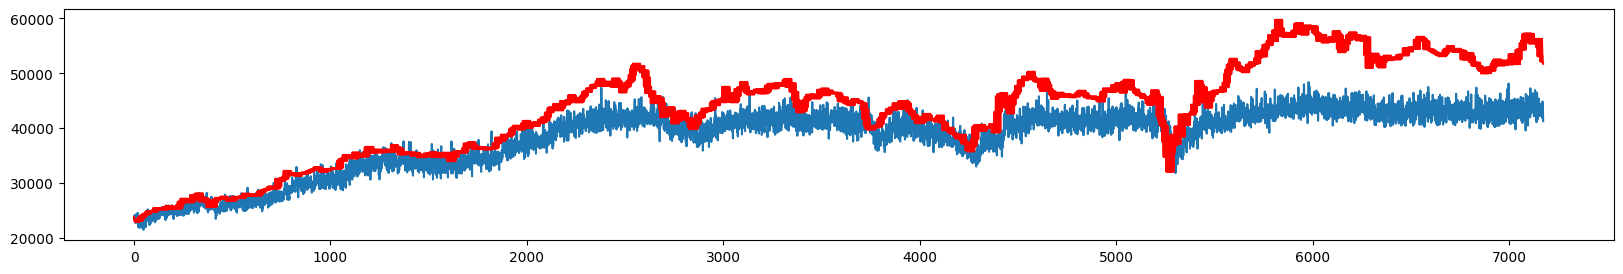

 90%|████████████████████████████████████████████████████████████████████████▉        | 9/10 [1:19:44<05:17, 317.76s/it]

Epoch 1/100
132/132 [==============================] - ETA: 0s - loss: 0.0022 - mae: 0.0332
Epoch 1: val_loss improved from inf to 0.01273, saving model to ./weights_transformer/CIPLA.csv.h5
132/132 [==============================] - 24s 181ms/step - loss: 0.0022 - mae: 0.0332 - val_loss: 0.0127 - val_mae: 0.0736
Epoch 2/100
132/132 [==============================] - ETA: 0s - loss: 0.0019 - mae: 0.0314
Epoch 2: val_loss improved from 0.01273 to 0.01122, saving model to ./weights_transformer/CIPLA.csv.h5
132/132 [==============================] - 24s 180ms/step - loss: 0.0019 - mae: 0.0314 - val_loss: 0.0112 - val_mae: 0.0815
Epoch 3/100
132/132 [==============================] - ETA: 0s - loss: 0.0015 - mae: 0.0266
Epoch 3: val_loss improved from 0.01122 to 0.00828, saving model to ./weights_transformer/CIPLA.csv.h5
132/132 [==============================] - 24s 181ms/step - loss: 0.0015 - mae: 0.0266 - val_loss: 0.0083 - val_mae: 0.0678
Epoch 4/100
132/132 [==========================

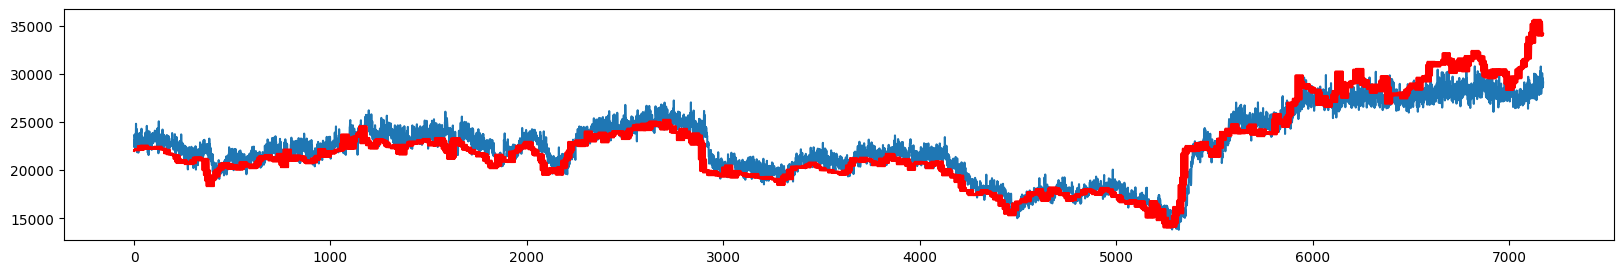

100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [1:22:55<00:00, 497.53s/it]


In [9]:
i = -1
rmse = []
maes = []
for file in tqdm(files):
    i += 1
    # scaler = scalers[i]
    x_train , y_train , x_test , y_test, scaler = fetch_data(file, scaler)

    weights_dir = './weights_transformer/'


    os.makedirs(weights_dir, exist_ok=True)
    file_name = file + '.h5'
    file_path = os.path.join(weights_dir, file_name)

    # ModelCheckpoint to save the best model weights
    mc1 = ModelCheckpoint(file_path,  # Path to save weights
                         monitor='val_loss',  # Monitor validation loss
                         mode='min',  # We want to minimize the loss
                         save_best_only=True,  # Save only the best weights
                         verbose=1)  # Display when saving occurs

    es1 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

    x_train=np.asarray(x_train).astype(np.float32)
    #x_val=np.asarray(x_val).astype(np.float32)
    x_test=np.asarray(x_test).astype(np.float32)

    y_train=np.asarray(y_train).astype(np.float32)
    #y_val=np.asarray(y_val).astype(np.float32)
    y_test=np.asarray(y_test).astype(np.float32)

    hist1=transformer_model.fit(x_train,y_train,batch_size=32,epochs=100, verbose = 1,callbacks=[es1,mc1],
                   validation_data=(x_test,y_test))

    transformer_model.load_weights(file_path)

    
    # x_test = scaler.transform(x_test)
    pred = transformer_model.predict(x_test)

    if pred.ndim == 3:
    # Flatten 3D array (samples, timesteps, features) to 2D
        pred_shape = pred.shape
        pred = pred.reshape(pred_shape[0] * pred_shape[1], pred_shape[2])

    # Apply inverse transform
    pred_unscaled = scaler.inverse_transform(pred)

    # Same for y_test if it's 3D
    if y_test.ndim == 3:
        y_test_shape = y_test.shape
        y_test = y_test.reshape(y_test_shape[0] * y_test_shape[1], y_test_shape[2])

    y_test_unscaled = scaler.inverse_transform(y_test)

    plt.figure(figsize=(20,3))
    plt.plot(pred_unscaled.flatten())
    plt.plot(y_test_unscaled.flatten(),color='red')
    plt.show()
    # print(mean_square_error(y_test, pred))
    rmse.append(root_mean_square_error(y_test_unscaled, pred_unscaled))
    maes.append(mean_absolute_error(y_test_unscaled, pred_unscaled))

In [10]:
print(rmse)
print(maes)

[774.16249101852, 8797.440536883441, 296.9882284072889, 333.13363028220374, 635.4267758758675, 2448.2456984543032, 67.64094803861416, 416.62948167406495, 6469.314337702258, 1536.425152749069]
[334.88116, 5742.418, 222.52264, 234.01326, 456.47046, 1657.3458, 49.034412, 326.8563, 5174.1245, 1143.5878]
